In [1]:
import sys
import glob
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import matplotlib.pyplot as plt
from clisops.core.subset import subset_shape
import cartopy.crs as ccrs
import numpy as np
import geopandas as gp
import xesmf as xe

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

Matplotlib is building the font cache; this may take a moment.


In [2]:
shape = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/australia/australia.shp')

xmin = 112.92
xmax = 153.63
ymin = -43.625
ymax = -10.07 

In [3]:
hist_dict = {
    'ACCESS-CM2': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/v20210607/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_*.nc')),
    'ACCESS-ESM1-5': sorted(glob.glob('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/day/pr/gn/v20200529/pr_day_ACCESS-ESM1-5_historical_r6i1p1f1_gn_*.nc')),
    'CESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/historical/r11i1p1f1/day/pr/gn/v20190514/*.nc')),
    'CMCC-ESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/day/pr/gn/v20210114/pr_day_CMCC-ESM2_historical_r1i1p1f1_gn_*.nc')),
    'CNRM-ESM2-1': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/day/pr/gr/v20181206/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_*.nc')),
    'EC-Earth3': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/day/pr/gr/v20200310/pr_day_EC-Earth3_historical_r1i1p1f1_gr_*.nc')),
    'MPI-ESM1-2-HR': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/day/pr/gn/v20190710/pr_day_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_*.nc')),
    'NorESM2-MM': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_*.nc')),
    'UKESM1-0-LL': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/pr/gn/v20190627/pr_day_UKESM1-0-LL_historical_r1i1p1f2_gn_*.nc')),
}

In [4]:
ssp_dict = {
    'ACCESS-CM2': sorted(glob.glob('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/gn/v20210712/*.nc')),
    'ACCESS-ESM1-5': sorted(glob.glob('/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/gn/v20200908/*.nc')),
    'CESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCAR/CESM2/ssp370/r11i1p1f1/day/pr/gn/v20200528/*.nc')),
    'CMCC-ESM2': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp370/r1i1p1f1/day/pr/gn/v20210202/*.nc')),
    'CNRM-ESM2-1': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp370/r1i1p1f2/day/pr/gr/v20191021/*.nc')),
    'EC-Earth3': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp370/r1i1p1f1/day/pr/gr/v20200310/*.nc')),
    'MPI-ESM1-2-HR': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1-2-HR/ssp370/r1i1p1f1/day/pr/gn/v20190710/*.nc')),
    'NorESM2-MM': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp370/r1i1p1f1/day/pr/gn/v20191108/*.nc')),
    'UKESM1-0-LL': sorted(glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp370/r1i1p1f2/day/pr/gn/v20190726/*.nc')),
}

In [31]:
model_list = list(hist_dict.keys())
#model_list = ['CMCC-ESM2',]

## QDC change

In [6]:
barra_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

In [7]:
ds_barra = utils.read_data(
    barra_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
    lat_bounds=[ymin, ymax],
    lon_bounds=[xmin, xmax],
)
try:
    ds_barra = ds_barra.drop_vars('crs')
except ValueError:
    pass

In [8]:
da_barra_clim = ds_barra['pr'].groupby('time.month').mean('time')

In [9]:
da_barra_clim = da_barra_clim.compute()

In [40]:
da_barra_annual_clim = ds_barra['pr'].mean('time')
da_barra_annual_clim = da_barra_annual_clim.compute()

In [9]:
#agcd_files = sorted(glob.glob("/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc"))

In [10]:
#ds_agcd = utils.read_data(
#    agcd_files,
#    'precip',
#    time_bounds=['1985', '2014'],
#    input_units="mm day-1",
#    output_units="mm day-1",
#)
#try:
#    ds_agcd = ds_agcd.drop_vars('crs')
#except ValueError:
#    pass

In [11]:
#da_agcd_clim = ds_agcd['precip'].groupby('time.month').mean('time')

In [12]:
#da_agcd_clim = da_agcd_clim.compute()

In [33]:
qdc_change_dict = {}
for model in model_list:
    print(model)
    qdc_files = glob.glob(f'/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/{model}/ssp370/r*/day/pr/2070-2099/pr_day_{model}_ssp370_r*_AUS-11_*_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc')
    ds_qdc = utils.read_data(
        qdc_files,
        'pr',
        time_bounds=['2070', '2099'],
        input_units="mm day-1",
        output_units="mm day-1",
        lat_bounds=[ymin, ymax],
        lon_bounds=[xmin, xmax],
    )
    try:
        ds_qdc = ds_qdc.drop_vars('crs')
    except ValueError:
        pass
    da_qdc_clim = ds_qdc['pr'].groupby('time.month').mean('time')
    da_qdc_clim = da_qdc_clim.compute()
    qdc_change_dict[model] = da_qdc_clim - da_barra_clim

ACCESS-CM2
ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3
MPI-ESM1-2-HR
NorESM2-MM
UKESM1-0-LL


In [49]:
diff_max_dict = {}
for model in model_list:
    print(model)
    hist_files = hist_dict[model]
    ds_hist = utils.read_data(
        hist_files,
        'pr',
        time_bounds=['1985', '2014'],
        input_units="kg m-2 s-1",
        output_units="mm day-1",
    )
    try:
        ds_hist = ds_hist.drop_vars('crs')
    except ValueError:
        pass
    da_hist_clim = ds_hist['pr'].groupby('time.month').mean('time')
        
    ssp_files = ssp_dict[model]
    ds_ssp = utils.read_data(
        ssp_files,
        'pr',
        time_bounds=['2070', '2099'],
        input_units="kg m-2 s-1",
        output_units="mm day-1",
    )
    try:
        ds_ssp = ds_ssp.drop_vars('crs')
    except ValueError:
        pass
    da_ssp_clim = ds_ssp['pr'].groupby('time.month').mean('time')

    regridder = xe.Regridder(da_hist_clim, da_barra_clim, 'bilinear')
    da_hist_clim_regridded = regridder(da_hist_clim)
    da_ssp_clim_regridded = regridder(da_ssp_clim)
        
    da_model_change_regridded = da_ssp_clim_regridded - da_hist_clim_regridded
    #diff = (qdc_change_dict[model] - da_model_change_regridded) / da_barra_clim.clip(min=0.1, keep_attrs=True)
    diff = (qdc_change_dict[model] - da_model_change_regridded) / da_barra_annual_clim
        
    diff_max = diff.max(dim='month')
    diff_max = subset_shape(diff_max, shape=shape)
    diff_max_dict[model] = diff_max.compute()

ACCESS-CM2
ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3
MPI-ESM1-2-HR
NorESM2-MM
UKESM1-0-LL


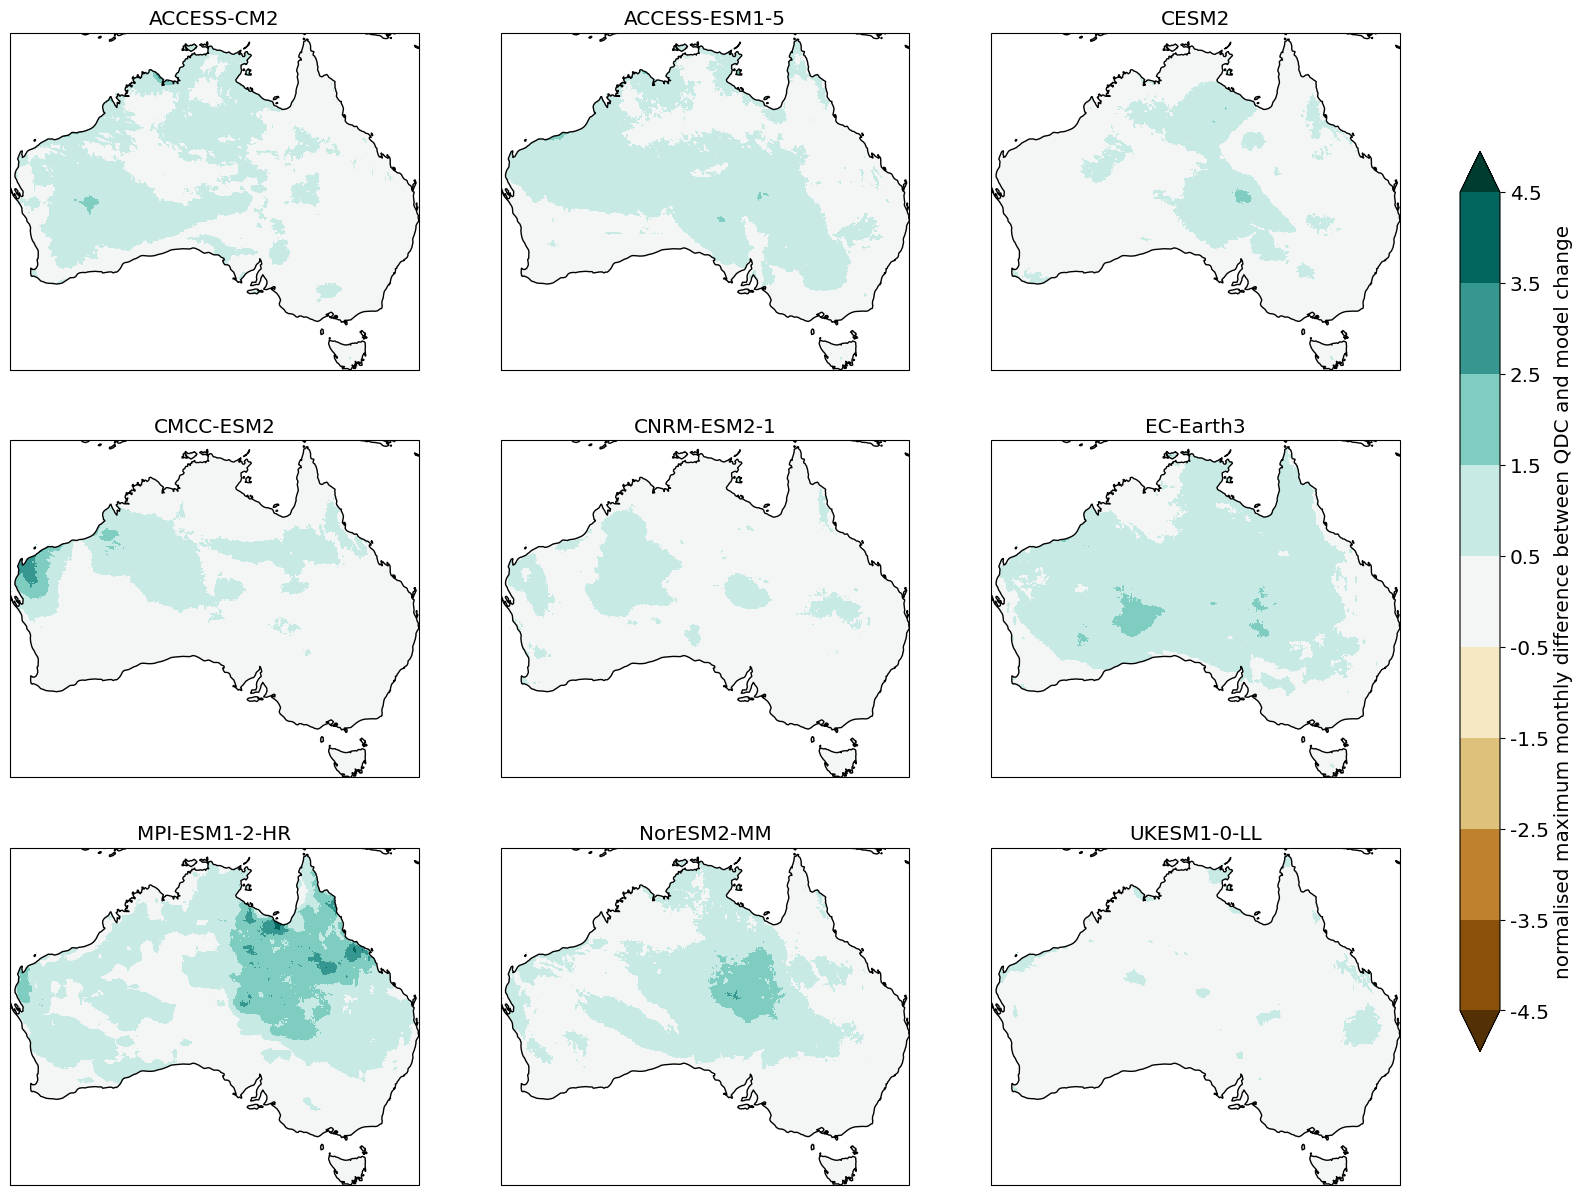

In [50]:
levels = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
fig = plt.figure(figsize=[20, 15])
for plotnum, model in enumerate(model_list): 
    ax = fig.add_subplot(3, 3, plotnum + 1, projection=ccrs.PlateCarree(central_longitude=180))
    im = diff_max_dict[model].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='BrBG',
        levels=levels,
        extend='both',
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title(model, size='x-large')
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize='x-large')
cbar.set_ticks(ticks=levels, labels=levels)
cbar.set_label('normalised maximum monthly difference between QDC and model change', size='x-large')

plt.savefig(
    f'max_monthly_additive_change_difference_BARRA-R2_norm-annual-clim.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()